# Regression Engine to predict Arrival Delay

In this notebook we are going to buils a model to predict the delay time of flights.

Table of contents:

1. [Import relevant libraries](#Libraries)
2. [Load files](#Load)
3. [Preview files](#Preview)
5. [Data exploration and transformation](#Exploration)
6. [Target distribution](#Target)
7. [Outliers](#Outliers)
8. [Correlations](#Correlations)
9. [Model training](#Model)
10. [Test set predictions](#Predictions)
11. [Creating a submission file](#Submission)
12. [Tips to improve model performance](#Tips)

<a name = "Libraries"></a>
## 1. Import relevant libraries

In [76]:
# Pre-requisites
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno

# Store the regression models to save time
import joblib

# Preprocessing
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

# Classifiers from scikit-learn
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.ensemble import GradientBoostingRegressor

# Performance metrics
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score

pd.set_option('display.max_columns', None)

<a name = "Load"></a>
## 2. Load files

In [77]:
file_path = 'processed.parquet'

# Read the file using pandas
df = pd.read_parquet(file_path)

<a name = "Preview"></a>
## 3. Preview files

In [78]:
df.head()

,aircraft,airport,rounded_hour,date,from,to,flight,flight_time,scheduled_time_departure,actual_time_departure,scheduled_time_arrival,status,actual_time_arrival,from_city,to_city,delay_time,temperature,dew_point,humidity,wind_speed,wind_gust,pressure,precip,my_flightradar24_rating,arrival_delay_index,departure_delay_index,msn,type,airline,age,departure_delay,departure_delay_15,year,month,day,hour,dayofweek,quarter,is_year_start,is_year_end
0,67,crl,2023-08-18 22:00:00,2023-08-18,157,7,329,1.016667,2023-08-18 19:30:00,2023-08-18 19:59:00,2023-08-18 21:50:00,0,2023-08-18 22:00:00,142,6,10.0,73,68,83,6,0,29.260000,0.0,63,0.4,1.2,96,10,58,16.0,29.0,1,2023,8,18,21,4,3,0,0
1,37,bah,2023-08-21 22:00:00,2023-08-21,80,3,257,0.900000,2023-08-20 23:04:00,2023-08-21 22:10:00,2023-08-21 22:04:00,0,2023-08-21 22:04:00,72,3,0.0,95,84,71,9,0,29.580000,0.0,78,0.4,0.8,71,15,25,24.0,1386.0,1,2023,8,21,22,0,3,0,0
2,113,vie,2023-10-08 21:00:00,2023-10-08,107,22,635,1.316667,2023-10-08 19:00:00,2023-10-08 19:07:00,2023-10-08 20:35:00,0,2023-10-08 20:26:00,88,20,-9.0,54,45,72,7,0,29.700001,0.0,85,0.4,0.7,155,21,66,7.0,7.0,0,2023,10,8,20,6,4,0,0
3,15,bru,2024-01-25 12:00:00,2024-01-25,71,5,789,8.233333,2024-01-25 19:50:00,2024-01-25 20:28:00,2024-01-25 11:55:00,0,2024-01-25 11:42:00,69,6,-13.0,45,45,100,7,0,30.280001,0.0,81,0.4,0.8,65,12,62,23.0,38.0,1,2024,1,25,11,3,1,0,0
4,159,msq,2024-03-28 19:00:00,2024-03-28,138,17,206,1.066667,2024-03-28 17:10:00,2024-03-28 17:22:00,2024-03-28 18:45:00,0,2024-03-28 18:25:00,221,15,-20.0,50,37,62,13,20,28.820000,0.0,71,2.5,2.5,135,10,55,5.0,12.0,0,2024,3,28,18,3,1,0,0


<a name = "Exploration"></a>
## 5. Data exploration and transformation

Axes(0.125,0.125;0.698618x0.755)


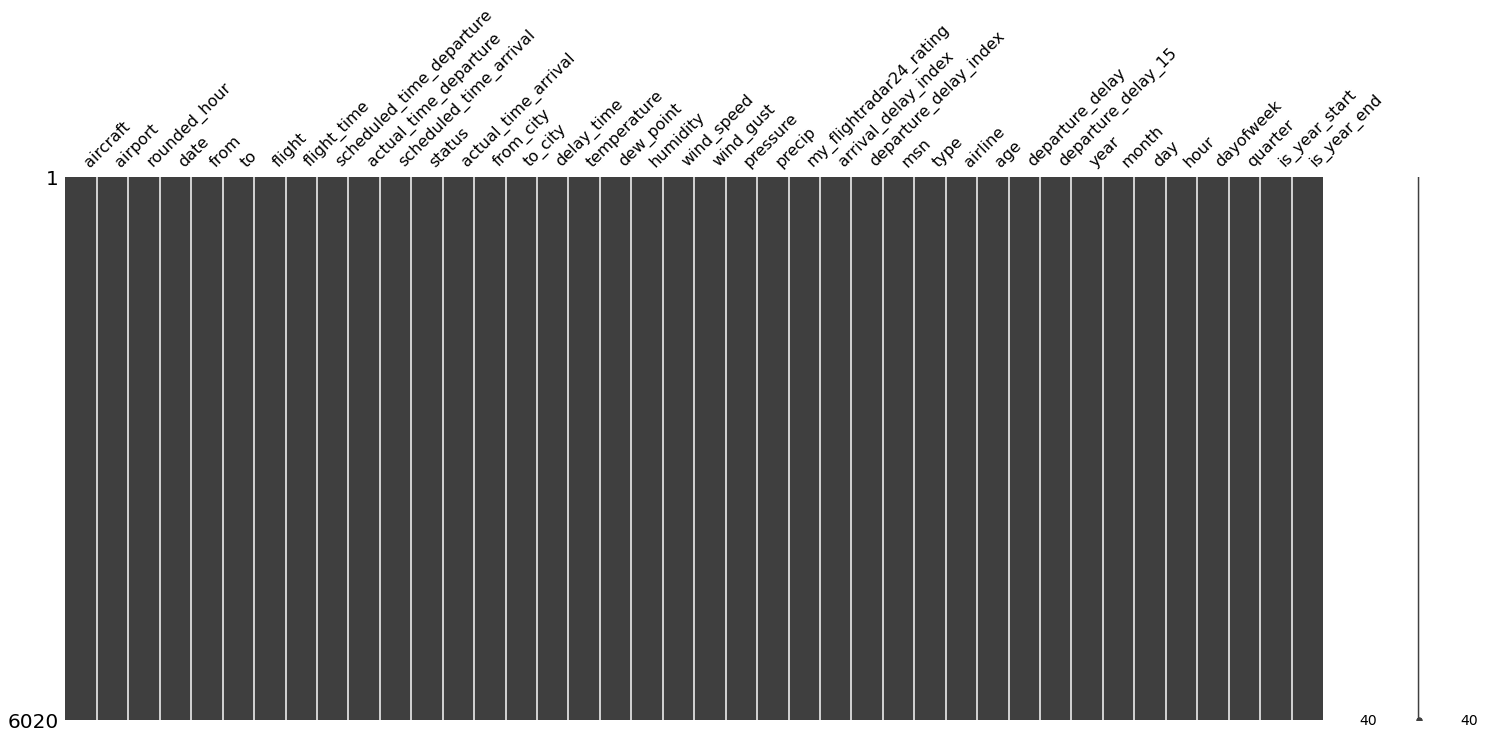

In [79]:
print(msno.matrix(df))

In [80]:
df.dropna(inplace=True)

In [81]:
# Check for any missing values
df.isnull().sum().any()

False

In [82]:
df = df[df['status']==1]

df["arrival_delay"] = df["actual_time_arrival"] - df["scheduled_time_arrival"]
# Convert the arrival delay to minutes
df['arrival_delay'] = df['arrival_delay'].dt.total_seconds() / 60



In [83]:
cols = ['flight', 'aircraft', 'from', 'to', 
       'flight_time', 'from_city',
       'to_city', 'temperature', 'dew_point', 'humidity',
       'wind_speed', 'wind_gust', 'pressure', 'precip',
       'my_flightradar24_rating', 'arrival_delay_index',
       'departure_delay_index', 'msn', 'type', 'airline', 'age',
       'year', 'month', 'day', 'hour',
       'dayofweek', 'quarter', 'is_year_start', 'is_year_end', 'arrival_delay']

df = df[cols]

In [84]:
# Show the first few rows of the DataFrame
df.head()

,flight,aircraft,from,to,flight_time,from_city,to_city,temperature,dew_point,humidity,wind_speed,wind_gust,pressure,precip,my_flightradar24_rating,arrival_delay_index,departure_delay_index,msn,type,airline,age,year,month,day,hour,dayofweek,quarter,is_year_start,is_year_end,arrival_delay
6,447,68,54,7,1.316667,51,6,77,61,57,7,0,29.290001,0.0,63,0.4,1.2,97,10,58,16.000000,2023,9,11,15,0,3,0,0,16.0
12,398,67,137,7,1.283333,226,6,70,55,60,5,0,29.600000,0.0,63,0.4,1.2,96,10,58,16.000000,2023,9,4,10,0,3,0,0,193.0
13,327,8,94,5,1.733333,201,6,68,57,68,5,0,29.920000,0.0,81,0.4,0.8,151,10,58,8.000000,2023,9,26,17,1,3,0,0,101.0
17,45,169,123,17,3.633333,107,15,32,30,93,7,0,29.230000,0.0,71,2.5,2.5,186,8,64,14.334871,2024,1,26,21,4,1,0,0,55.0
27,282,67,147,7,2.433333,127,6,59,46,63,6,0,29.110001,0.0,63,0.4,1.2,96,10,58,16.000000,2023,8,30,17,2,3,0,0,40.0


In [85]:
# Check statistical summaries of the dataset
df.describe()

,flight,aircraft,from,to,flight_time,from_city,to_city,temperature,dew_point,humidity,wind_speed,wind_gust,pressure,precip,my_flightradar24_rating,arrival_delay_index,departure_delay_index,msn,type,airline,age,year,month,day,hour,dayofweek,quarter,is_year_start,is_year_end,arrival_delay
count,1235.000000,1235.000000,1235.000000,1235.000000,1235.000000,1235.000000,1235.000000,1235.000000,1235.000000,1235.000000,1235.000000,1235.000000,1235.000000,1235.0,1235.000000,1235.000000,1235.000000,1235.000000,1235.000000,1235.000000,1235.000000,1235.000000,1235.000000,1235.000000,1235.000000,1235.000000,1235.000000,1235.000000,1235.000000,1235.000000
mean,473.756275,93.719838,132.422672,9.821862,3.301646,127.400000,9.048583,57.166802,46.621053,72.429960,9.774899,1.680972,29.448463,0.0,74.207287,0.988988,1.414656,89.493117,10.326316,43.548988,13.053052,2023.269636,6.842915,15.317409,13.056680,3.021862,2.623482,0.002429,0.000810,62.789474
std,254.102966,52.694904,76.904556,6.493159,2.774133,70.743301,5.770537,16.361685,13.514643,19.791594,5.740006,6.985996,0.977820,0.0,9.564205,0.921299,0.837940,55.387764,6.999623,21.801034,5.772716,0.443950,3.642617,8.831191,5.888623,1.996027,1.131514,0.049246,0.028456,121.488036
min,3.000000,1.000000,0.000000,0.000000,0.350000,0.000000,0.000000,7.000000,-15.000000,0.000000,0.000000,0.000000,0.000000,0.0,45.000000,0.400000,0.100000,1.000000,0.000000,0.000000,2.000000,2023.000000,1.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,16.000000
25%,274.000000,59.000000,76.500000,5.000000,1.283333,76.500000,6.000000,46.000000,39.000000,60.000000,6.000000,0.000000,29.214999,0.0,63.000000,0.400000,0.800000,38.000000,5.000000,19.000000,10.000000,2023.000000,4.000000,8.000000,9.000000,1.000000,2.000000,0.000000,0.000000,23.000000
50%,479.000000,85.000000,123.000000,7.000000,2.250000,127.000000,6.000000,57.000000,48.000000,76.000000,9.000000,0.000000,29.490000,0.0,79.000000,0.400000,1.200000,87.000000,10.000000,55.000000,14.334871,2023.000000,7.000000,15.000000,13.000000,3.000000,3.000000,0.000000,0.000000,34.000000
75%,693.000000,145.000000,188.000000,16.000000,4.841667,180.000000,14.000000,66.000000,55.000000,88.000000,13.000000,0.000000,29.830000,0.0,81.000000,2.500000,2.500000,132.500000,10.000000,58.000000,16.000000,2024.000000,10.000000,23.000000,18.000000,5.000000,4.000000,0.000000,0.000000,62.000000
max,936.000000,199.000000,277.000000,22.000000,14.016667,260.000000,21.000000,111.000000,88.000000,100.000000,36.000000,51.000000,30.540001,0.0,85.000000,2.500000,3.500000,200.000000,30.000000,78.000000,40.000000,2024.000000,12.000000,31.000000,23.000000,6.000000,4.000000,1.000000,1.000000,1429.000000


In [86]:
df.dtypes

flight                       int32
aircraft                     int32
from                         int32
to                           int32
flight_time                float64
from_city                    int32
to_city                      int32
temperature                  int32
dew_point                    int32
humidity                     int32
wind_speed                   int32
wind_gust                    int32
pressure                   float32
precip                     float32
my_flightradar24_rating      int32
arrival_delay_index        float32
departure_delay_index      float32
msn                          int32
type                         int32
airline                      int32
age                        float64
year                         int64
month                        int64
day                          int64
hour                         int64
dayofweek                    int64
quarter                      int64
is_year_start                int32
is_year_end         

<a name = "Target"></a>
## 6. Target variable distribution

C:\Users\MSI\AppData\Local\Programs\Python\Python39\lib\site-packages\seaborn\axisgrid.py:88: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


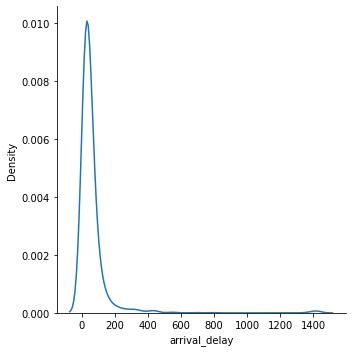

In [87]:
sns.displot(df, x="arrival_delay", kind="kde")

<a name = "Model"></a>
## 9. Model training

In [88]:
X = df.loc[:, df.columns != "arrival_delay"]
y = np.array(df.loc[:, df.columns == "arrival_delay"]["arrival_delay"])

In [89]:
print(f"\nDataset shape: {df.shape}")
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)
print(f"features_train shape: {X_train.shape} | features_test shape: {X_test.shape}")
print(f"labels_train shape: {y_train.shape} | labels_test shape: {y_test.shape}")


Dataset shape: (1235, 30)
features_train shape: (988, 29) | features_test shape: (247, 29)
labels_train shape: (988,) | labels_test shape: (247,)


In [90]:
def print_metrics(labels_test, model_pred, regressor_name):

    mse = mean_squared_error(labels_test, model_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(labels_test, model_pred)
    r2 = r2_score(labels_test, model_pred)

    print(f"MSE      : {mse}", end="\n\n")
    print(f"RMSE     : {rmse}", end="\n\n")
    print(f"MAE      : {mae}", end="\n\n")
    print(f"R2 Score : {r2}", end="\n\n")

## Linear Regression

In [91]:
model = LinearRegression(n_jobs=-1)
model.fit(X_train, y_train)

LinearRegression(n_jobs=-1)

In [92]:
model_pred = model.predict(X_test)
print_metrics(y_test, model_pred, "LinearRegression")

MSE      : 10299.194298639864

RMSE     : 101.48494616759604

MAE      : 45.21611190937011

R2 Score : 0.024752867780290067



In [93]:
# Save the model
joblib.dump(model, 'regressors/linear_regression_regressor.joblib')

['regressors/linear_regression_regressor.joblib']

## Decision Tree Regressor

In [94]:
model = DecisionTreeRegressor()
model.fit(X_train, y_train)

DecisionTreeRegressor()

In [95]:
model_pred = model.predict(X_test)
print_metrics(y_test, model_pred, "DecisionTreeRegressor")

MSE      : 26505.433198380568

RMSE     : 162.80489304188794

MAE      : 55.587044534412954

R2 Score : -1.5098417376566498



In [96]:
# Save the model
joblib.dump(model, 'regressors/decision_tree_regressor.joblib')

['regressors/decision_tree_regressor.joblib']

## XGBoost

In [97]:
model = GradientBoostingRegressor()
model.fit(X_train, y_train)

GradientBoostingRegressor()

In [98]:
model_pred = model.predict(X_test)
print_metrics(y_test, model_pred, "GradientBoostingRegressor")

MSE      : 23114.047160391405

RMSE     : 152.0330462774176

MAE      : 49.36732075262896

R2 Score : -1.1887059854905138



In [99]:
# Save the model
joblib.dump(model, 'regressors/xgboost_regressor.joblib')

['regressors/xgboost_regressor.joblib']

## Random Forest

In [100]:
model = RandomForestRegressor()
model.fit(X_train, y_train)

RandomForestRegressor()

In [101]:
model_pred = model.predict(X_test)
print_metrics(y_test, model_pred, "RandomForestRegressor")

MSE      : 18268.440607692304

RMSE     : 135.16079537977092

MAE      : 48.8814979757085

R2 Score : -0.7298677737472015



In [102]:
# Save the model
joblib.dump(model, 'regressors/random_forest_regressor.joblib')

['regressors/random_forest_regressor.joblib']

Text(0, 0.5, 'Features')

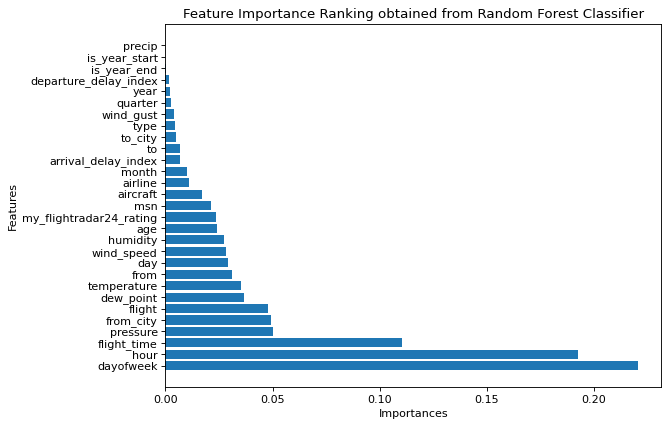

In [103]:
importances = pd.DataFrame({
    "Feature": list(X.columns),
    "Importance": model.feature_importances_
})
importances = importances.sort_values(by="Importance", ascending=False)
importances = importances.set_index("Feature")
importances
plt.figure(figsize=(8, 6), dpi=80)
plt.barh(importances.index, importances.Importance)
plt.title("Feature Importance Ranking obtained from Random Forest Classifier", fontsize=12)
plt.xlabel("Importances")
plt.ylabel("Features")

## To Do
- Fine tuning
- Model validation
